In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.integrate import quad
from numpy.lib.scimath import sqrt

# ------------------------------------------------------------
#  DEFINITIONS
# ------------------------------------------------------------

c0 = 3e8        
lam = 550e-1 
omega = 2*np.pi*c0/lam
k0 = 2*np.pi/lam

def eps(i):
    if i == 1:
        return 1.0
    elif i == 2:
        return -10 + 1j*1.2 
    else:
        return 1.45**2

def kz(i,kpar,k0):
    return sqrt(eps(i)*k0**2-kpar**2 + 0j)

def rsp(k0,t,kpar,pol='s'):
    """
    pol: 'p' or 's' polarization
    """  
    def r12(pol):
        if pol == 's':
            return (kz(1,kpar,k0) - kz(2,kpar,k0)) / (kz(1,kpar,k0) + kz(2,kpar,k0))
        else:
            return (eps(2)*kz(1,kpar,k0) - eps(1)*kz(2,kpar,k0)) / (eps(2)*kz(1,kpar,k0) + eps(1)*kz(2,kpar,k0))

    def r23(pol):
        if pol == 's':
            return (kz(2,kpar,k0) - kz(3,kpar,k0)) / (kz(2,kpar,k0) + kz(3,kpar,k0))
        else:
            return (eps(3)*kz(2,kpar,k0)-eps(2)*kz(3,kpar,k0)) / (eps(3)*kz(2,kpar,k0)+eps(2)*kz(3,kpar,k0))

    A = r12(pol) + r23(pol)*np.exp(2j*kz(2,kpar,k0)*t)

    B = 1 + r12(pol)*r23(pol)*np.exp(2j*kz(2,kpar,k0)*t)
    
    return A / B

def Gij(kpar,z,zprime,phi,k0,i,j,r,t):
    """
    Subtract the i,j term of Green's Function matrix
    """
    j0 = jv(0, r * kpar)
    j1 = jv(1, r * kpar)
    j2 = jv(2, r * kpar)

    exp = (kpar/(sqrt(k0**2-kpar**2+0j))) * np.exp(1j*(sqrt(k0**2-kpar**2 +0j)*(z+zprime)))
    
    Grs = [
        [(1j*k0**2/2)*(j0+np.cos(2*phi)*j2), (1j*k0**2/2)*np.sin(2*phi)*j2, 0],
        [(1j*k0**2/2)*np.sin(2*phi)*j2, (1j*k0**2/2)*(j0-np.cos(2*phi)*j2), 0],
        [0, 0, 0]
    ]

    Grp = [
        [-(1j*kz(1,kpar,k0)**2/2)*(j0-np.cos(2*phi)*j2), (1j*kz(1,kpar,k0)**2/2)*np.sin(2*phi)*j2, kpar*kz(1,kpar,k0)*np.cos(phi)*j1],
        [(1j*kz(1,kpar,k0)**2/2)*np.sin(2*phi)*j2, -(1j*kz(1,kpar,k0)**2/2)*(j0+np.cos(2*phi)*j2), kpar*kz(1,kpar,k0)*np.sin(phi)*j1],
        [-kpar*kz(1,kpar,k0)*np.cos(phi)*j1, -kpar*kz(1,kpar,k0)*np.sin(phi)*j1, 1j*kpar**2*j0]
    ]
    
    return exp*(rsp(k0,t,kpar,pol='s')*Grs[i][j] + rsp(k0,t,kpar,pol='p')*Grp[i][j])

# ------------------------------------------------------------
#  CALCULATIONS
# ------------------------------------------------------------

In [48]:
## Z SWEEP

r = 30e-1
z = np.linspace(0, 1000e-1, 100) 

result_matrix = np.zeros((len(z)), dtype=complex)
phi = 0

zprime = 50e-1
t = 100e-1

result_matrix = np.zeros((len(z), 3, 3), dtype=complex)

for iz in range(len(z)):
    for i in range(3):
        for j in range(3):
            res, _ = quad(Gij, 0, np.inf, args=(z[iz], zprime, phi, k0, i, j, r, t), complex_func=True)
            result_matrix[iz, i, j] = res

/home/danielsarcanean/.local/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:441: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
/home/danielsarcanean/.local/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:444: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinu

In [ ]:
x = np.linspace(-50e-9, 50e-9, 5) 
y = np.linspace(-50e-9, 50e-9, 5) 
z = np.linspace(-300e-9, 300e-9, 50) 

zprime = 25e-9 
t = 100e-9

i = 2
j = 2

result_matrix = np.zeros((len(x), len(y), len(z)), dtype=complex)

for ix in range(len(x)):
    for iy in range(len(y)):
        for iz in range(len(z)):
            valR = sqrt(x[ix]**2 + y[iy]**2)
            valPhi = np.arccos(x[ix]/valR)
            res_real, _ = quad(lambda kpar: np.real(Gij(iz,zprime,valPhi,kpar,k0,i,j,valR)), 0, np.inf)
            res_imag, err_im = quad(lambda kpar: np.imag(Gij(iz,zprime,valPhi,kpar,k0,i,j,valR)), 0, np.inf)
            result_matrix[ix, iy, iz] = res_real + 1j*res_imag

In [ ]:
print(result_matrix)

/tmp/ipykernel_6188/581597507.py:94: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  res_real, _ = quad(lambda kpar: np.real(Gij(iz,zprime,valPhi,kpar,k0,i,j,valR)), 0, np.inf)
/tmp/ipykernel_6188/581597507.py:95: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res_imag, err_im = quad(lambda kpar: np.imag(Gij(iz,zprime,valPhi,kpar,k0,i,j,valR)), 0, np.inf)
/tmp/ipykernel_6188/581597507.py:95: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  res_imag, err_im = quad(lambda kpar: np.imag(Gij(iz,zprime,valPhi,kpar,k0,i,j,valR)), 

[[[ 7.08164018e+17+1.33734943e-05j -1.51514137e+17-8.73151147e+16j
   -9.76947921e+01+8.40078842e+16j ... -2.50451775e+19+2.81997861e+18j
    8.16678298e+02-2.60577234e+19j  1.05325326e+16-1.74503370e+17j]
  [ 1.31586805e-06+1.33739492e-05j -1.51514137e+17-8.73151147e+16j
   -9.76947921e+01+8.40078842e+16j ... -2.50451775e+19+2.81997861e+18j
    8.16678298e+02-2.60577234e+19j  1.05325326e+16-1.74503370e+17j]
  [ 7.08164018e+17+1.33727144e-05j -1.51514137e+17-8.73151147e+16j
   -9.76947921e+01+8.40078842e+16j ... -2.50451775e+19+2.81997861e+18j
    8.16678298e+02-2.60577234e+19j  1.05325326e+16-1.74503370e+17j]
  [ 1.31586805e-06+1.33739492e-05j -1.51514137e+17-8.73151147e+16j
   -9.76947921e+01+8.40078842e+16j ... -2.50451775e+19+2.81997861e+18j
    8.16678298e+02-2.60577234e+19j  1.05325326e+16-1.74503370e+17j]
  [ 7.08164018e+17+1.33734943e-05j -1.51514137e+17-8.73151147e+16j
   -9.76947921e+01+8.40078842e+16j ... -2.50451775e+19+2.81997861e+18j
    8.16678298e+02-2.60577234e+19j  1.

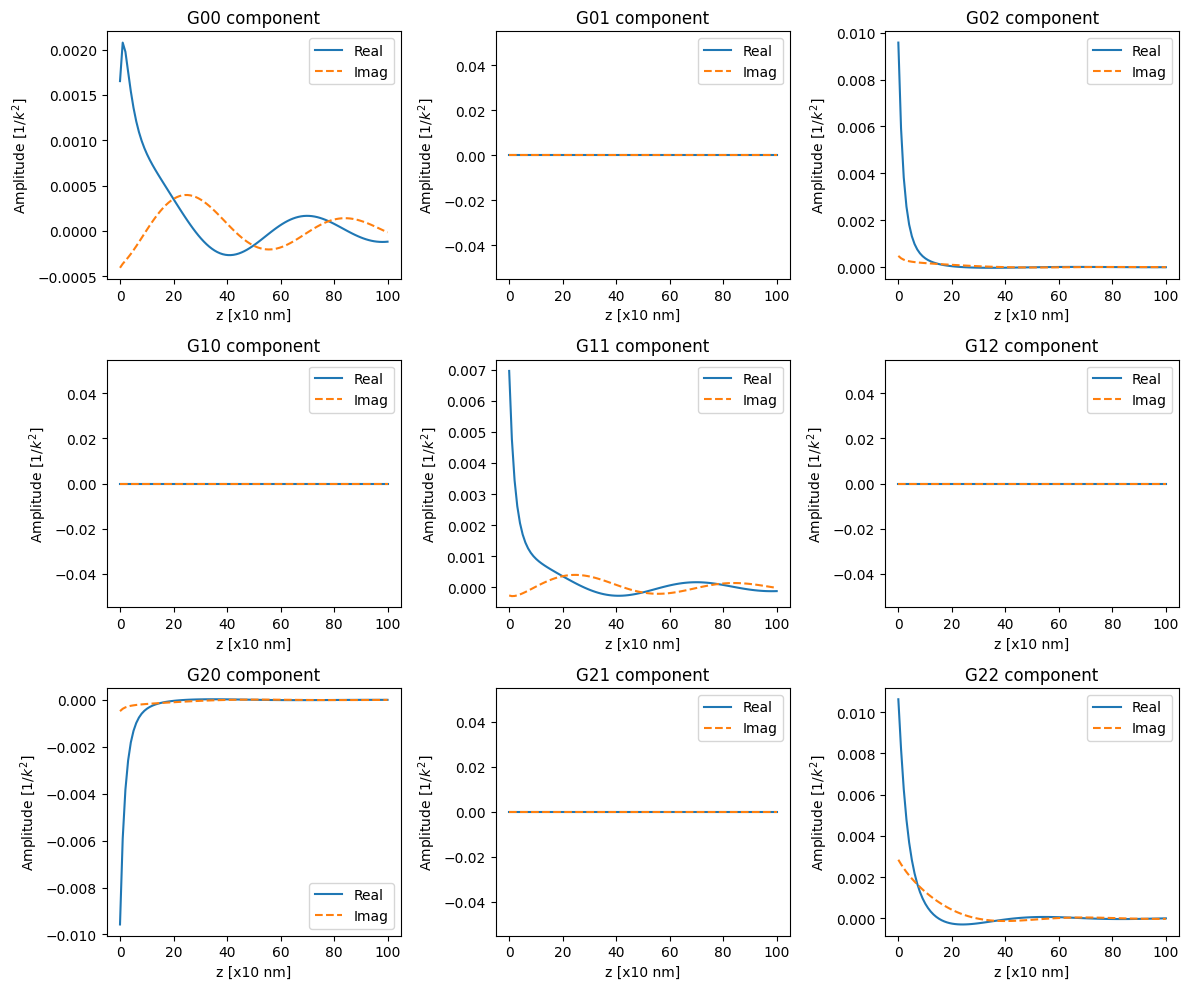

In [49]:
# ------------------------------------------------------------
#  PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]  # Subplot (i,j)
        
        # Extraer la componente (i,j) en función de z
        values = result_matrix[:, i, j]
        
        # Graficar parte real e imaginaria
        ax.plot(z, np.real(values), label='Real')
        ax.plot(z, np.imag(values), '--', label='Imag')
        
        ax.set_xlabel('z [x10 nm]')
        ax.set_ylabel('Amplitude [1/$k^2$]')
        ax.set_title(f'G{i}{j} component')
        ax.legend()

plt.tight_layout()
plt.savefig('Zdependency.png', dpi=300, bbox_inches='tight')
plt.show()


In [59]:
## R SWEEP

r = np.linspace(0, 1000e-1, 100) 
z = 25e-1
phi = np.pi/4

zprime = 50e-1
t = 100e-1

result_matrix = np.zeros((len(r), 3, 3), dtype=complex)

for iz in range(len(r)):
    for i in range(3):
        for j in range(3):
            res, _ = quad(Gij, 0, np.inf, args=(z, zprime, phi, k0, i, j, r[iz], t), complex_func=True)
            result_matrix[iz, i, j] = res

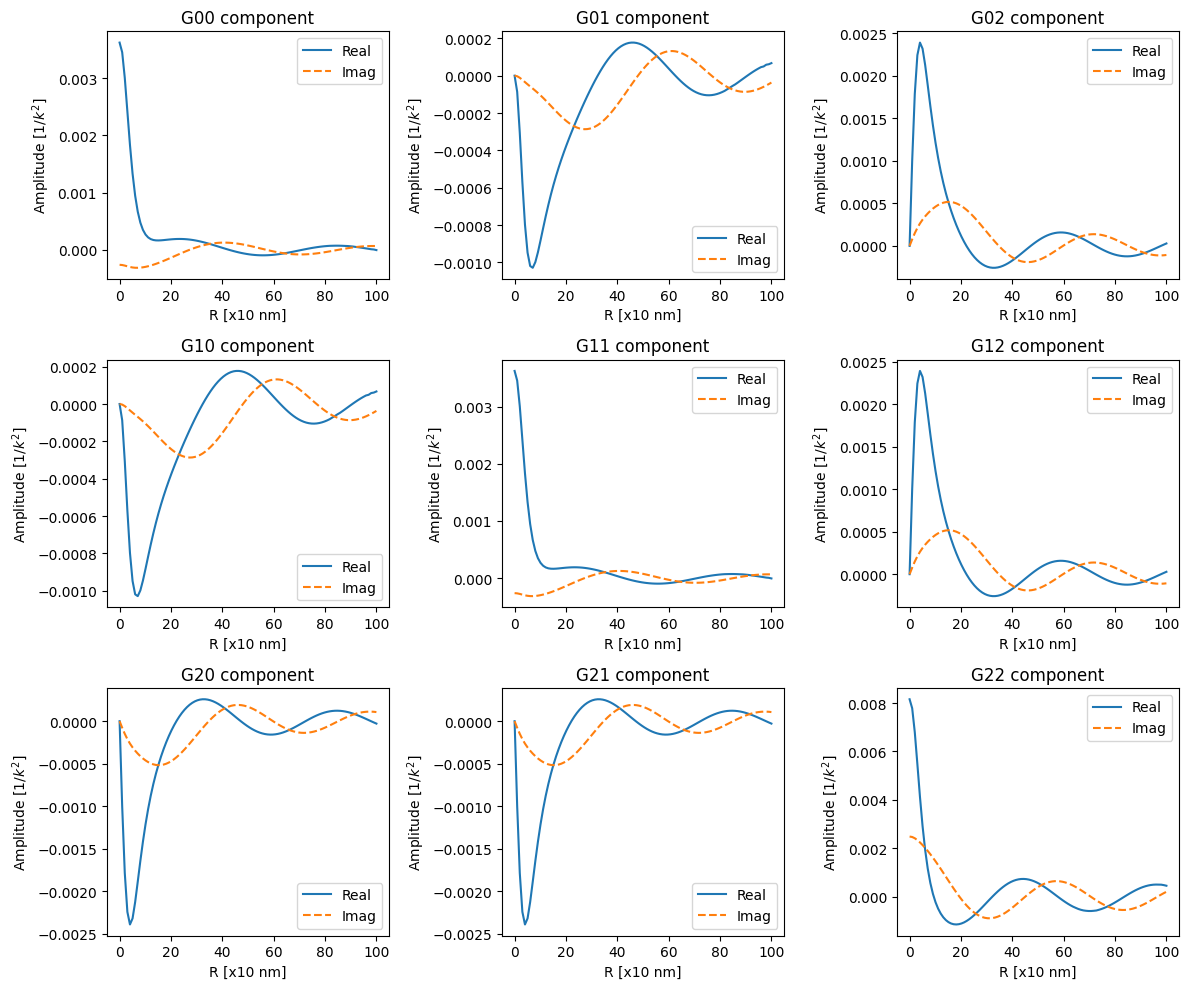

In [60]:
# ------------------------------------------------------------
#  PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]  # Subplot (i,j)
        
        # Extraer la componente (i,j) en función de z
        values = result_matrix[:, i, j]
        
        # Graficar parte real e imaginaria
        ax.plot(r, np.real(values), label='Real')
        ax.plot(r, np.imag(values), '--', label='Imag')
        
        ax.set_xlabel('R [x10 nm]')
        ax.set_ylabel('Amplitude [1/$k^2$]')
        ax.set_title(f'G{i}{j} component')
        ax.legend()

plt.tight_layout()
plt.savefig('R3dependency.png', dpi=300, bbox_inches='tight')
plt.show()

In [53]:
## T SWEEP

r = 0
z = 25e-1

phi = 0

zprime = 50e-1
t = np.linspace(0, 500e-1, 100) 

result_matrix = np.zeros((len(t), 3, 3), dtype=complex)

for iz in range(len(t)):
    for i in range(3):
        for j in range(3):
            res, _ = quad(Gij, 0, np.inf, args=(z, zprime, phi, k0, i, j, r, t[iz]), complex_func=True)
            result_matrix[iz, i, j] = res

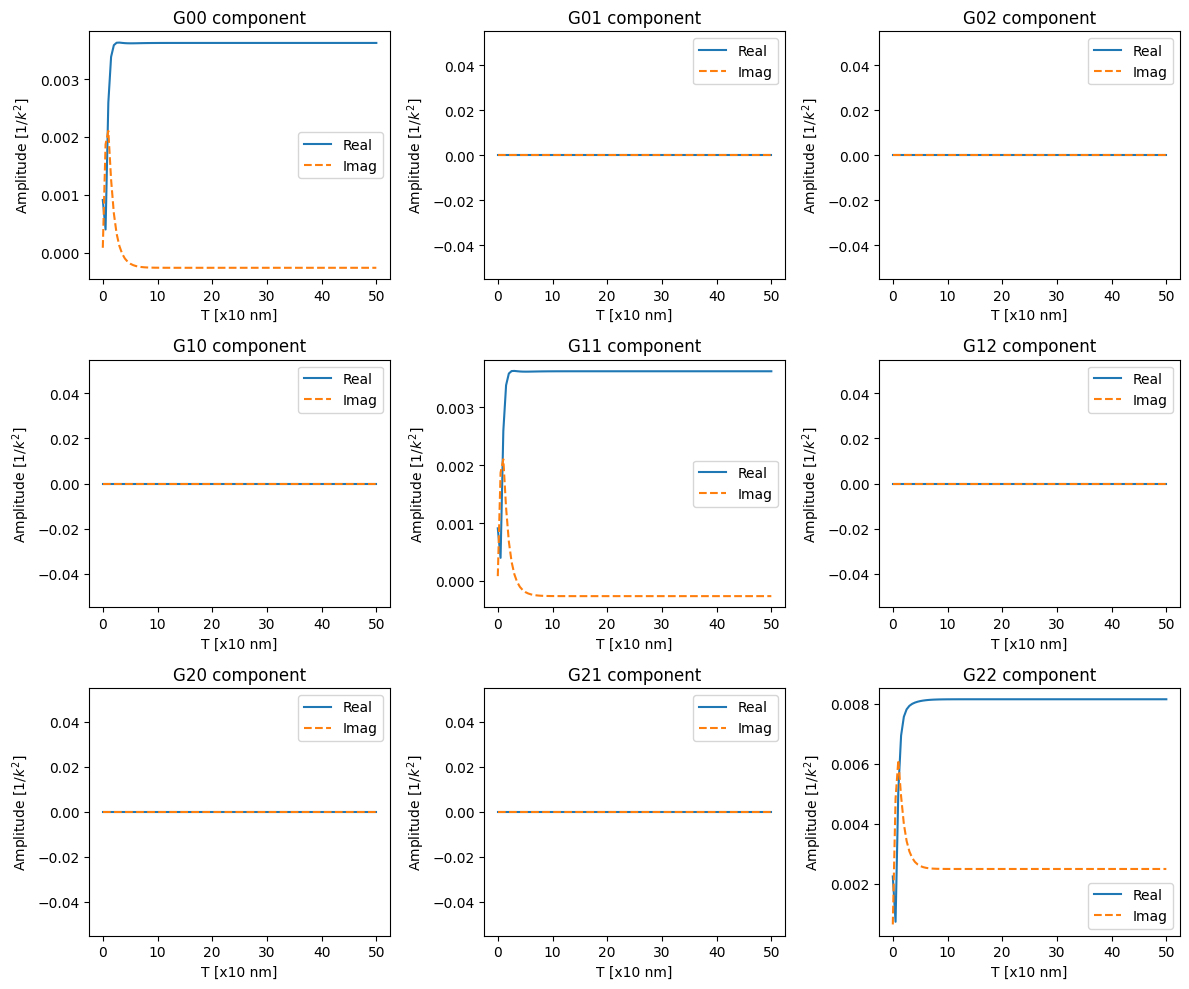

In [54]:
# ------------------------------------------------------------
#  PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]  # Subplot (i,j)
        
        # Extraer la componente (i,j) en función de z
        values = result_matrix[:, i, j]
        
        # Graficar parte real e imaginaria
        ax.plot(t, np.real(values), label='Real')
        ax.plot(t, np.imag(values), '--', label='Imag')
        
        ax.set_xlabel('T [x10 nm]')
        ax.set_ylabel('Amplitude [1/$k^2$]')
        ax.set_title(f'G{i}{j} component')
        ax.legend()

plt.tight_layout()
plt.savefig('Tdependency.png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
## phi SWEEP

r = 30e-1
z = 25e-1

phi = np.linspace(0, 10, 100) 

zprime = 50e-1
t = 100e-1

result_matrix = np.zeros((len(phi), 3, 3), dtype=complex)

for iz in range(len(phi)):
    for i in range(3):
        for j in range(3):
            res, _ = quad(Gij, 0, np.inf, args=(z, zprime, phi[iz], k0, i, j, r, t), complex_func=True)
            result_matrix[iz, i, j] = res

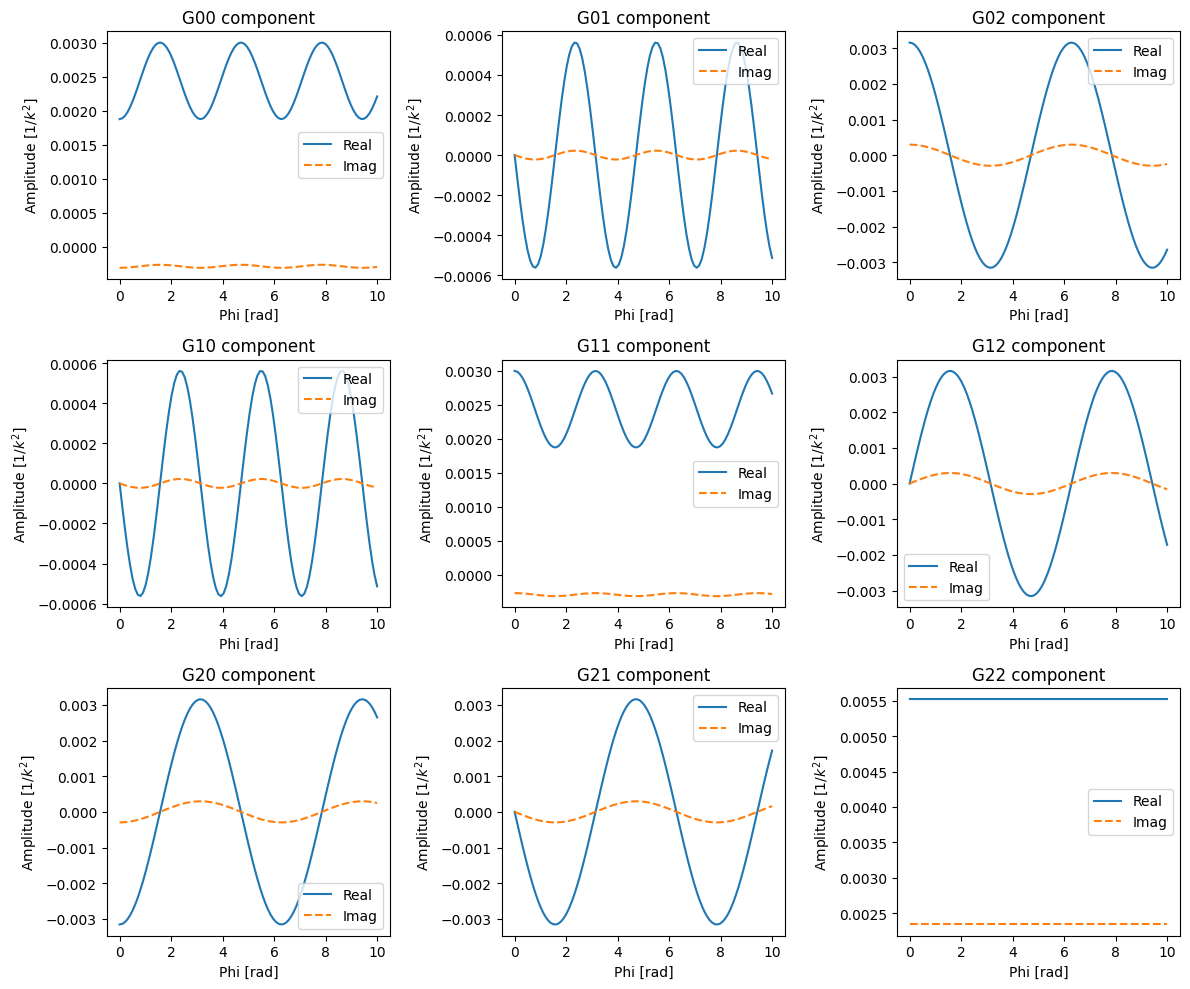

In [56]:
# ------------------------------------------------------------
#  PLOTS
# ------------------------------------------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))

for i in range(3):
    for j in range(3):
        ax = axes[i, j]  # Subplot (i,j)
        
        # Extraer la componente (i,j) en función de z
        values = result_matrix[:, i, j]
        
        # Graficar parte real e imaginaria
        ax.plot(phi, np.real(values), label='Real')
        ax.plot(phi, np.imag(values), '--', label='Imag')
        
        ax.set_xlabel('Phi [rad]')
        ax.set_ylabel('Amplitude [1/$k^2$]')
        ax.set_title(f'G{i}{j} component')
        ax.legend()

plt.tight_layout()
plt.savefig('phidependency.png', dpi=300, bbox_inches='tight')
plt.show()